## Value at Risk
https://github.com/hardikroutray/QuantitativeFinance/blob/main/Value_at_Risk.ipynb

### VaR = I (  $\mu$ $\delta$T -  $\sigma$ $\sqrt\delta T$ z )

where 

### I = Investment, $\delta$T = Time period,  $\mu$ = Mean return,  $\sigma$ = Mean volatility
### z = z-score for required Confidence Level say 95%


In [2]:
import numpy as np
import yfinance as yf
from scipy.stats import norm
import pandas as pd
import datetime
import matplotlib.pyplot as plt

## Exact solution

In [3]:
def download_data(stock, start_date, end_date):
    data = {}
    ticker = yf.download(stock, start_date, end_date)
    data[stock] = ticker['Adj Close']
    return pd.DataFrame(data)


#  calculate the VaR tomorrow (n=1)
def calculate_var(position, c, mu, sigma):
    var = position * (mu - sigma * norm.ppf(1-c))
    return var


#  calculate the VaR for any days in the future
def calculate_var_n(position, c, mu, sigma, n):
    var = position * (mu * n - sigma * np.sqrt(n) * norm.ppf(1-c))
    return var

In [4]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2022, 10, 10)

stock_data = download_data('C', start, end)

stock_data['returns'] = np.log(stock_data['C'] / stock_data['C'].shift(1))
stock_data = stock_data[1:]
# print(stock_data)

# this is the investment (stocks or whatever)
S = 1e6
# confidence level - set it to 95% initially
c = 0.99

# we assume that daily returns are normally distributed
mu = np.mean(stock_data['returns'])
sigma = np.std(stock_data['returns'])

print(r'Value at risk for 1 day at 95 percent CL is: $%0.2f' % calculate_var_n(S, c, mu, sigma, 1))
print(r'Value at risk for 1 month at 95 percent CL is: $%0.2f' % calculate_var_n(S, c, mu, sigma, 30))

[*********************100%***********************]  1 of 1 completed
Value at risk for 1 day at 95 percent CL is: $48643.31
Value at risk for 1 month at 95 percent CL is: $265992.92


## Monte Carlo


In [7]:
def download_data(stock, start, end):
    data = {}
    ticker = yf.download(stock, start, end)
    data['Adj Close'] = ticker['Adj Close']
    return pd.DataFrame(data)

class ValueAtRiskMonteCarlo:
    
    def __init__(self, S, mu, sigma, c, n, iterations):
        self.S = S
        self.mu = mu
        self.sigma = sigma
        self.c = c
        self.n = n
        self.iterations = iterations

    def simulation(self):
        stock_data = np.zeros([self.iterations, 1])
        rand = np.random.normal(0, 1, [1, self.iterations])

        # equation for the S(t) stock price
        stock_price = self.S * np.exp(self.n * (self.mu - 0.5 * self.sigma ** 2) + self.sigma * np.sqrt(self.n) * rand)

        # we have to sort the stock prices to determine the percentile
        stock_price = np.sort(stock_price)

#         fig = plt.figure(figsize=(10,5))
#         plt.hist(stock_price,bins=100)
#         plt.yscale('log')
#         plt.xlim(-1,100)
#         plt.show()
        
        # it depends on the confidence level: 95% -> 5 and 99% -> 1
        percentile = np.percentile(stock_price, (1 - self.c) * 100)

        return self.S - percentile, stock_price

[*********************100%***********************]  1 of 1 completed


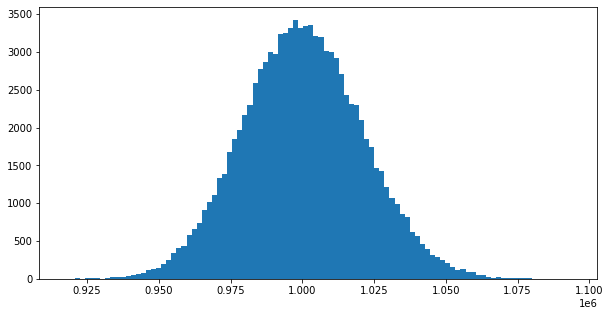

Value at risk for 1 day at 95 percent CL is: $33634.30


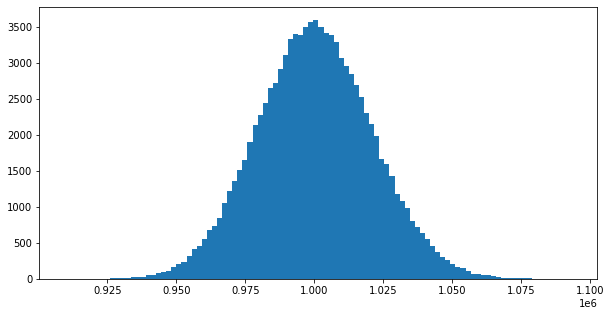

Value at risk for 1 month at 95 percent CL is: $172205.98


In [13]:
S = 1e6  # this is the investment (stocks or whatever)
c = 0.95  # condifence level: this time it is 99%
n = 1  # 1 day
iterations = 100000  # number of paths in the Monte-Carlo simulation

# historical data to approximate mean and standard deviation
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2022, 10, 10)

# download stock related data from Yahoo Finance
citi = download_data('C', start_date, end_date)

# we can use pct_change() to calculate daily returns
citi['returns'] = citi['Adj Close'].pct_change()

# we can assume daily returns to be normally sidtributed: mean and variance (standard deviation)
# can describe the process
mu = np.mean(citi['returns'])
sigma = np.std(citi['returns'])

model1 = ValueAtRiskMonteCarlo(S, mu, sigma, c, n, iterations)
model2 = ValueAtRiskMonteCarlo(S, mu, sigma, c, 30, iterations)

# print('Value at risk with Monte-Carlo simulation: $%0.2f' % model.simulation())

fig = plt.figure(figsize=(10,5))
plt.hist(model1.simulation()[1].flatten(),bins=100)
# plt.yscale('log')
# plt.xlim(-1,100)
plt.show()

# print(model1.simulation()[1])
      
print(r'Value at risk for 1 day at 95 percent CL is: $%0.2f' % model1.simulation()[0])

fig = plt.figure(figsize=(10,5))
plt.hist(model1.simulation()[1].flatten(),bins=100)
# plt.yscale('log')
# plt.xlim(-1,100)
plt.show()
print(r'Value at risk for 1 month at 95 percent CL is: $%0.2f' % model2.simulation()[0])

